# Proyecto Series de Tiempo Univariadas
El siguiente Script abarca las metodologías vistas en el semestre 2024-1 de Series de Tiempo Univariadas desarrolladas en Python, utilizando la medición de la tasa de desempleo en Colombia; desde enero de 2001 hasta diciembre de 2023.

#### Integrantes: Anderson Guarín, Ander Cristancho, Juan Duitama

## Librerías utilizadas

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pylab as plt
import statsmodels.api as sm
import datetime as dt
import scipy as sp
import scipy.stats 

import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import keras_tuner as kt
from tensorflow.keras import layers
from sklearn.model_selection import KFold, TimeSeriesSplit, GridSearchCV

## Importación base de datos

In [3]:
import os
os.chdir(r"C:\Users\EQUIPO\OneDrive\Documentos\Documentos Ander\UNAL\Series de tiempo\Mis series y descriptiva")
os.getcwd()

'C:\\Users\\EQUIPO\\OneDrive\\Documentos\\Documentos Ander\\UNAL\\Series de tiempo\\Mis series y descriptiva'

In [4]:
Data = pd.read_excel("Desempleo.xlsx",skiprows=5,nrows=277)
Data = Data.iloc[:,[0,2]]
print(Data.dtypes)
# Cambiar los nombres de las columnas
nuevos_nombres = ['AnioMes', 'TasaDesempleo']
Data.columns = nuevos_nombres
Data

Año-Mes (AAAA-MM)         object
Tasa de desempleo (%)    float64
dtype: object


,AnioMes,TasaDesempleo
0,2023-12,10.013717
1,2023-11,9.007386
2,2023-10,9.230912
3,2023-09,9.252674
4,2023-08,9.277372
...,...,...
271,2001-05,14.035800
272,2001-04,14.515100
273,2001-03,15.811900
274,2001-02,17.434200


## Gráfica de la tasa de desempleo en Colombia

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


Text(0.5, 1.0, 'Tasa de desempleo mensual en Colombia')

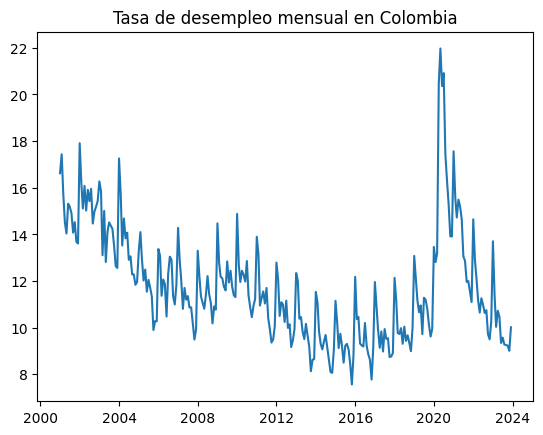

In [5]:
#Primera observación de los datos
Data['AnioMes']=pd.to_datetime(Data['AnioMes'])#Convirtiendo la columna año y mes a formato fecha
Desempleo1=Data.set_index('AnioMes')#Ordenando el dataframe, pero creo uno nuevo para volverlo objeto de series de tiempo luego
print(type(Desempleo1))
#Convirtiendo el data frame en objeto serie de tiempo
DesempleoTS=Desempleo1['TasaDesempleo']
print(type(DesempleoTS))
plt.plot(DesempleoTS)#Haciendo un primer gráfico de la serie de tiempo
plt.title('Tasa de desempleo mensual en Colombia') 

# Agregando componentes de Fourier

In [6]:
day = 24*60*60
year = (365.2425)*day

AnioyMes = Data['AnioMes']
AnioyMes = AnioyMes.map(pd.Timestamp.timestamp) ###Convierte las fechas a float
Data['AnioSin'] = np.sin(AnioyMes * (2 * np.pi / year))
Data['AnioCos'] = np.cos(AnioyMes * (2 * np.pi / year))
Data

,AnioMes,TasaDesempleo,AnioSin,AnioCos
0,2023-12-01,10.013717,-0.509773,0.860309
1,2023-11-01,9.007386,-0.867922,0.496700
2,2023-10-01,9.230912,-0.999909,-0.013493
3,2023-09-01,9.252674,-0.863021,-0.505168
4,2023-08-01,9.277372,-0.486373,-0.873751
...,...,...,...,...
271,2001-05-01,14.035800,0.876700,-0.481037
272,2001-04-01,14.515100,0.999899,0.014246
273,2001-03-01,15.811900,0.853812,0.520582
274,2001-02-01,17.434200,0.515496,0.856892


# Modelamiento utilizando Redes Neuronales
## Redes Neuronales Multicapa(MLP)


In [7]:
NuevaConf = pd.DataFrame(Data['TasaDesempleo'].iloc[::-1].values,index=pd.date_range(start='2001-01-01', end='2023-12-01', freq='MS') )
from pandas import DataFrame
df2 = DataFrame()#Creando un DataFrame vacío para luego llenar
for i in range(12,0,-1):
    df2[['t-'+str(i)]] = NuevaConf.shift(i)#El método shift() se encarga de desplazar las filas i veces hacia abajo
    
#for i in range(6,1,-1):   

Estacionalidad = "fourier" # dummy para estacionalidad dummy, fourier para componentes de tipo fourier, otra cosa para no hacer ninguno de estos 2

if Estacionalidad == "dummy":
    
    df2.reset_index(inplace=True)
    df2.rename(columns={'index': 'Fecha'}, inplace=True)
    df2['Fecha']=pd.to_datetime(df2['Fecha'])  

    meses = {
        2: 'Febrero',
        3: 'Marzo',
        4: 'Abril',
        5: 'Mayo',
        6: 'Junio',
        7: 'Julio',
        8: 'Agosto',
        9: 'Septiembre',
        10: 'Octubre',
        11: 'Noviembre',
        12: 'Diciembre'
    }

    df2['Mes'] = df2['Fecha'].dt.month
    dummies = pd.get_dummies(df2['Mes'], prefix='Mes', drop_first=True)  # drop_first=True para evitar la multicolinealidad
    df2 = df2.join(dummies)   
    
    column_mapping = {f'Mes_{num}': name for num, name in meses.items()}
    df2.rename(columns=column_mapping, inplace=True)
    
    df2.set_index('Fecha', inplace=True)

elif Estacionalidad == "fourier":
    
    NuevaConf2 = pd.DataFrame(Data[['AnioSin','AnioCos']].values,index=pd.date_range(start='2001-01-01', end='2023-12-01', freq='MS') )
    df2[['Sin','Cos']] = NuevaConf2.values

df2['t'] = NuevaConf.values
df2 = df2[12:]
print(df2.head(10))

               t-12     t-11     t-10      t-9      t-8      t-7      t-6  \
2002-01-01  16.6223  17.4342  15.8119  14.5151  14.0358  15.3123  15.1838   
2002-02-01  17.4342  15.8119  14.5151  14.0358  15.3123  15.1838  14.9135   
2002-03-01  15.8119  14.5151  14.0358  15.3123  15.1838  14.9135  14.0741   
2002-04-01  14.5151  14.0358  15.3123  15.1838  14.9135  14.0741  14.5249   
2002-05-01  14.0358  15.3123  15.1838  14.9135  14.0741  14.5249  13.6822   
2002-06-01  15.3123  15.1838  14.9135  14.0741  14.5249  13.6822  13.6084   
2002-07-01  15.1838  14.9135  14.0741  14.5249  13.6822  13.6084  17.9099   
2002-08-01  14.9135  14.0741  14.5249  13.6822  13.6084  17.9099  16.1888   
2002-09-01  14.0741  14.5249  13.6822  13.6084  17.9099  16.1888  15.1114   
2002-10-01  14.5249  13.6822  13.6084  17.9099  16.1888  15.1114  16.0770   

                t-5      t-4      t-3      t-2      t-1       Sin       Cos  \
2002-01-01  14.9135  14.0741  14.5249  13.6822  13.6084 -0.506179  0.8624

División entrenamiento y prueba

In [8]:
Split2 = df2.values #Convirtiendo en NumpyArray
X1_2= Split2[:, 0:-1] #Selecciono todas las filas, y todas las columnas excepto la última que es la variable respuesta
y1_2 =Split2[:,-1] #Selecciono todas las filas y solo la última columna 

In [9]:
X_train_full, X_test, y_train_full, y_test=train_test_split(X1_2,y1_2,test_size=0.2, train_size=0.8,shuffle=False)

División del entrenamiento en entrenamiento y validación (los porcentajes los seleccioné así para que quede similar a los porcentajes 70,10,20 del modelo de árboles)

In [10]:
X_train, X_val, y_train, y_val=train_test_split(X_train_full,y_train_full,test_size=0.12, train_size=0.88,shuffle=False)

### Estandarización de las covariables

In [11]:
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_val=scaler.transform(X_val)
X_test=scaler.transform(X_test)

Las respuestas no se estandarizan

### Red Neuronal con una sola capa
Recordemos que los hiperparámetros de una red neuronal multicapa son la cantidad de capas, los nodos que tiene cada capa y la función de activación.
Para crear las capas se utiliza [], y se separan con comas. En este caso, hay una sola capa oculta, y una de salida (*keras.layers.Dense(1)*)
* *layers.Dense* - layers indica que voy a añadir una nueva capa, .Dense, que esa capa será Densa
* 64 son la cantidad de nodos que hay dentro de esa primera capa oculta.
* activation="relu","linear","tanh" indica que la función de activación es relu, tanh o lineal respectivamente
* *input_shape=X_train.shape[1:]* son la cantidad de columnas que tiene nuestro dataframe, en este caso 9(escogimos 9 retardos)
* La capa de salida *keras.layers.Dense(1)* tiene un 1 debido a que nuestra variable respuesta es univariada

Utilizaremos el error cuadrático medio como métrica y el optimizador adam.
Además, realizaremos 50 épocas, junto a un tamaño de lote=12(por defecto es 32, entonces tendré 185/12 lotes, 185 porque hay 185 datos de entrenamiento

In [12]:
ModMLP1=keras.models.Sequential([keras.layers.Dense(64,activation="relu",input_shape=X_train.shape[1:]),keras.layers.Dense(1)])
ModMLP1.summary()

C:\Users\EQUIPO\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,025 (4.00 KB)

 Trainable params: 1,025 (4.00 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
ModMLP1_1=keras.models.Sequential([keras.layers.Dense(64,activation="linear",input_shape=X_train.shape[1:]),keras.layers.Dense(1)])
ModMLP1_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 64)             │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,025 (4.00 KB)

 Trainable params: 1,025 (4.00 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
ModMLP1_2=keras.models.Sequential([keras.layers.Dense(64,activation="tanh",input_shape=X_train.shape[1:]),keras.layers.Dense(1)])
ModMLP1_2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,025 (4.00 KB)

 Trainable params: 1,025 (4.00 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
ModMLP1.compile(loss="mean_squared_error",optimizer="adam")
historyMod1=ModMLP1.fit(X_train,y_train,batch_size=12,epochs=50,validation_data=(X_val,y_val)) 

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 146.6442 - val_loss: 101.5398
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 134.0775 - val_loss: 92.6108
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 115.3931 - val_loss: 82.8661
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 98.3549 - val_loss: 72.5541
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 83.0961 - val_loss: 62.0076
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 65.3949 - val_loss: 51.7136
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 48.8043 - val_loss: 41.9009
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 36.5266 - val_loss: 33.1655
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25.2639 - val_loss: 25.8094
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15.9466 - val_loss: 20.0034
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.7099 - val_loss: 15.6669
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st

#### Comportamiento de la pérdida cuadrática en este conjunto de entrenamiento y validación

(185, 14)

<Axes: >

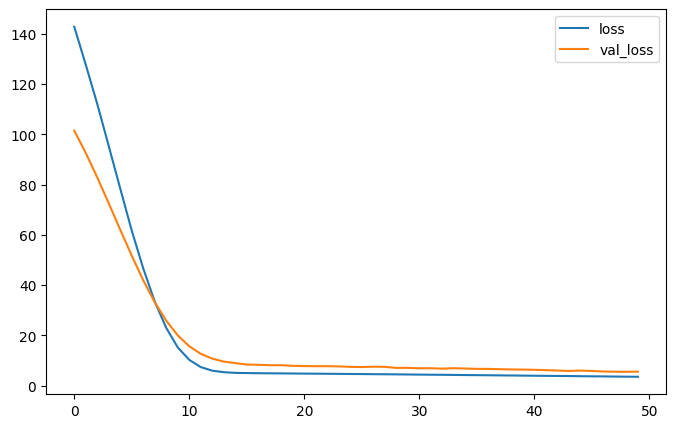

In [16]:
X_train.shape
pd.DataFrame(historyMod1.history).plot(figsize=(8,5))

In [17]:
mse_test1=ModMLP1.evaluate(X_test,y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.4766 


In [18]:
ypred1=ModMLP1.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


#### Gráfico de predicción y valores reales

<Figure size 600x600 with 0 Axes>

Text(0.5, 1.0, 'Real vs Predicción')

Text(0, 0.5, 'Tasa de Desempleo')

Text(0.5, 0, 'índice')

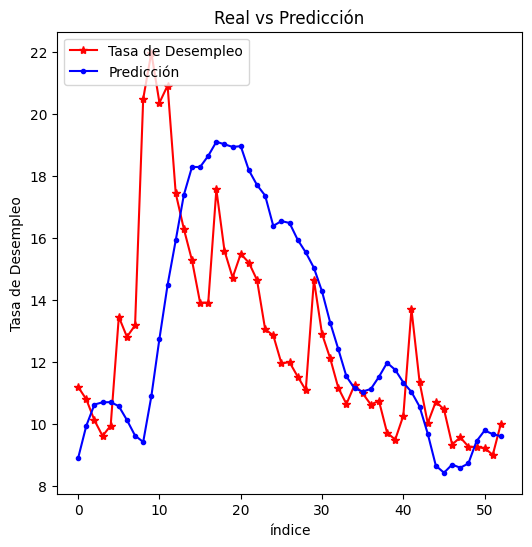

In [19]:
plt.figure(figsize=(6, 6))
plt.plot(range(y_test.size), y_test, linestyle='-', marker='*', color='r')
plt.plot(range(ypred1.size), ypred1, linestyle='-', marker='.', color='b') 
plt.legend(['Tasa de Desempleo','Predicción'], loc=2)
plt.title('Real vs Predicción')
plt.ylabel('Tasa de Desempleo')
plt.xlabel('índice')

No es un buen modelo prediciendo, no obstante, es entendible, puesto que el modelo intenta predecir la tasa de desempleo correspondiente al periodo de 2020 en adelante, el cual ya sabemos fue una época atípica para la humanidad. 

In [20]:
ModMLP1_1.compile(loss="mean_squared_error",optimizer="adam")
historyMod1_1=ModMLP1_1.fit(X_train,y_train,batch_size=12,epochs=50,validation_data=(X_val,y_val)) 

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 131.8433 - val_loss: 89.3389
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 110.7909 - val_loss: 72.9601
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 78.8574 - val_loss: 57.6717
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 52.5406 - val_loss: 43.3348
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 32.4557 - val_loss: 31.0749
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.7754 - val_loss: 21.4459
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.6018 - val_loss: 15.0721
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.5135 - val_loss: 11.4592
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.6068 - val_loss: 9.9117
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1455 - val_loss: 9.3806
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8616 - val_loss: 8.8708
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss

#### Comportamiento de la pérdida cuadrática en este conjunto de entrenamiento y validación

(185, 14)

<Axes: >

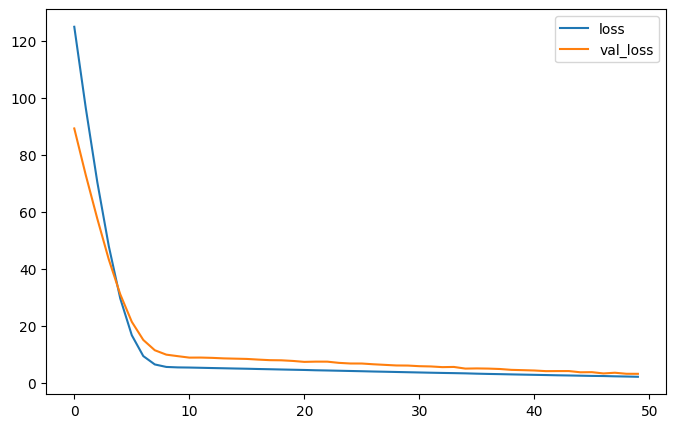

In [21]:
X_train.shape
pd.DataFrame(historyMod1_1.history).plot(figsize=(8,5))

In [22]:
mse_test1_1=ModMLP1_1.evaluate(X_test,y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.0160 


In [23]:
ypred1_1=ModMLP1_1.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


#### Gráfico de predicción y valores reales

<Figure size 600x600 with 0 Axes>

Text(0.5, 1.0, 'Real vs Predicción')

Text(0, 0.5, 'Tasa de Desempleo')

Text(0.5, 0, 'índice')

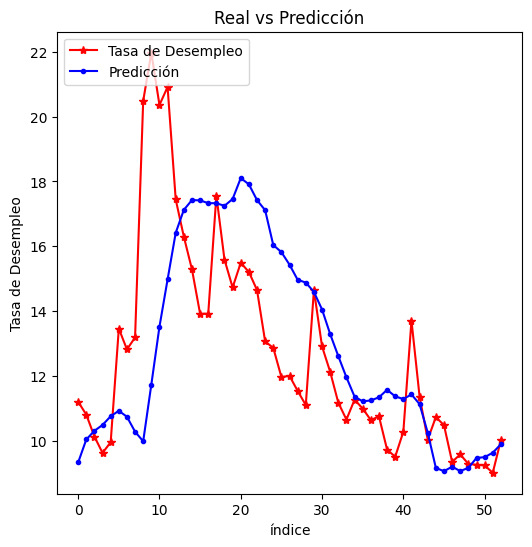

In [24]:
plt.figure(figsize=(6, 6))
plt.plot(range(y_test.size), y_test, linestyle='-', marker='*', color='r')
plt.plot(range(ypred1_1.size), ypred1_1, linestyle='-', marker='.', color='b') 
plt.legend(['Tasa de Desempleo','Predicción'], loc=2)
plt.title('Real vs Predicción')
plt.ylabel('Tasa de Desempleo')
plt.xlabel('índice')

Tampoco es buen modelo prediciendo, sin embargo, en cuanto a error cuadrático medio, este modelo presenta una disminución respecto al anterior.

In [25]:
ModMLP1_2.compile(loss="mean_squared_error",optimizer="adam")
historyMod1_2=ModMLP1_2.fit(X_train,y_train,batch_size=12,epochs=50,validation_data=(X_val,y_val)) 

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 127.2426 - val_loss: 83.7709
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 103.1540 - val_loss: 68.9481
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 75.3570 - val_loss: 54.8979
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 59.5989 - val_loss: 41.5901
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 39.8191 - val_loss: 30.2092
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25.4378 - val_loss: 21.0730
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.3118 - val_loss: 14.3563
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.2611 - val_loss: 9.7991
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5157 - val_loss: 6.9670
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6703 - val_loss: 5.2150
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9042 - val_loss: 4.1393
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss

#### Comportamiento de la pérdida cuadrática en este conjunto de entrenamiento y validación

(185, 14)

<Axes: >

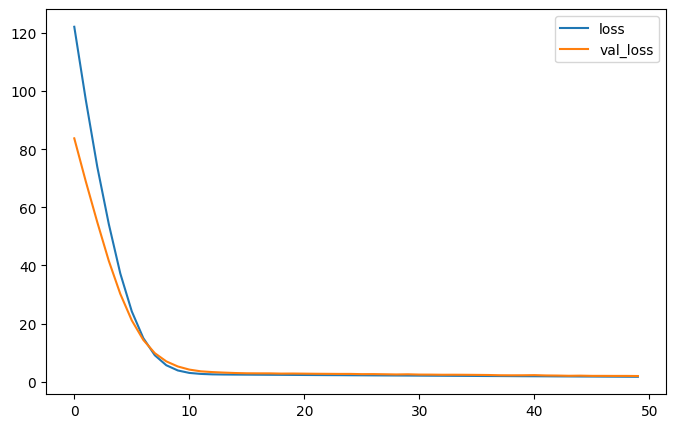

In [26]:
X_train.shape
pd.DataFrame(historyMod1_2.history).plot(figsize=(8,5))

In [27]:
mse_test1_2=ModMLP1_2.evaluate(X_test,y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.0308  


In [28]:
ypred1_2=ModMLP1_2.predict(X_test)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001DE9ADC32E0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


#### Gráfico de predicción y valores reales

<Figure size 600x600 with 0 Axes>

Text(0.5, 1.0, 'Real vs Predicción')

Text(0, 0.5, 'Tasa de Desempleo')

Text(0.5, 0, 'índice')

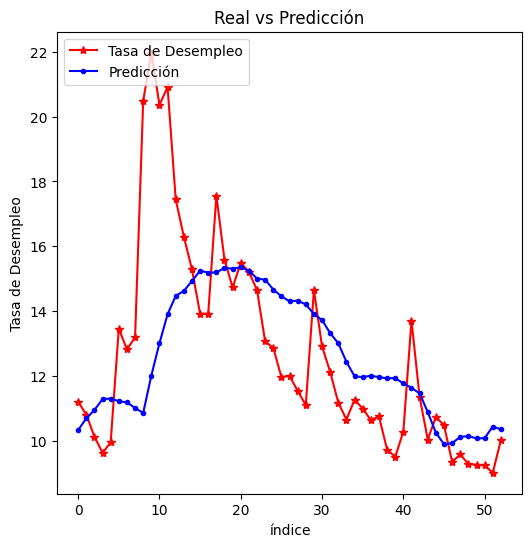

In [29]:
plt.figure(figsize=(6, 6))
plt.plot(range(y_test.size), y_test, linestyle='-', marker='*', color='r')
plt.plot(range(ypred1_2.size), ypred1_2, linestyle='-', marker='.', color='b') 
plt.legend(['Tasa de Desempleo','Predicción'], loc=2)
plt.title('Real vs Predicción')
plt.ylabel('Tasa de Desempleo')
plt.xlabel('índice')

### Red neuronal con más capas
La anterior red neuronal contó con una sola capa oculta, la siguiente red contará con tres capas ocultas, de 64, 32, y 16 nodos respectivamente.
Se harán distintas pruebas en cuanto a la función de activación y nos quedaremos con la mejor combinación, pero así como en el caso anterior, se utilizará un tamaño de lote igual a 12 y 50 épocas.

In [30]:
search = False

if search:

    funciones = ["relu","linear","tanh"]
    temp = 1000

    for i in funciones:
        for j in funciones:
            for k in funciones:
                for l in funciones:
                    input_layer = keras.layers.Input(shape=X_train.shape[1:])
                    hidden1 = keras.layers.Dense(64,activation=i)(input_layer)
                    hidden2 = keras.layers.Dense(32,activation=j)(hidden1)
                    hidden3 = keras.layers.Dense(16,activation=k)(hidden2)
                    output_layer = keras.layers.Dense(1, activation=l)(hidden3)
                
                    ModMLP2=keras.Model(inputs=[input_layer],outputs=[output_layer])
                    ModMLP2.compile(loss="mean_squared_error",optimizer="adam")
                    historyMod2=ModMLP2.fit(X_train,y_train,epochs=50,batch_size=12,validation_data=(X_val,y_val))
                
                    mse_test2=ModMLP2.evaluate(X_test,y_test)
                if mse_test2 <= temp:
                    temp = mse_test2
                    fun = [i,j,k,l]
                
    print(temp)                
    print(fun)

Epoch 26/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.8036 - val_loss: 1.3230
Epoch 27/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6406 - val_loss: 1.3952
Epoch 28/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0764 - val_loss: 1.4682
Epoch 29/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.2857 - val_loss: 1.5511
Epoch 30/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8922 - val_loss: 1.6368
Epoch 31/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1191 - val_loss: 1.7373
Epoch 32/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.6260 - val_loss: 1.8192
Epoch 33/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7374 - val_loss: 1.9029
Epoch 34/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2220 - val_loss: 1.9740
Epoch 35/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2719 - val_loss: 2.0478
Epoch 36/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.6682 - val_loss: 2.1290
Epoch 37/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7740

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.7452 - val_loss: 9.3176
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8260 - val_loss: 9.0311
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.6842 - val_loss: 8.0235
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3019 - val_loss: 7.6862
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5941 - val_loss: 7.2677
Epoch 13/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9405 - val_loss: 5.9726
Epoch 14/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1236 - val_loss: 5.9202
Epoch 15/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2211 - val_loss: 5.2221
Epoch 16/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7420 - val_loss: 4.8575
Epoch 17/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7050 - val_loss: 3.9013
Epoch 18/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1115 - val_loss: 3.5913
Epoch 19/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9849 - val_loss: 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 143.1327 - val_loss: 103.5256
Epoch 42/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 135.3681 - val_loss: 103.5256
Epoch 43/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 137.3737 - val_loss: 103.5256
Epoch 44/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 137.6001 - val_loss: 103.5256
Epoch 45/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 139.3473 - val_loss: 103.5256
Epoch 46/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 132.9669 - val_loss: 103.5256
Epoch 47/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 133.7575 - val_loss: 103.5256
Epoch 48/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 138.2171 - val_loss: 103.5256
Epoch 49/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 134.9242 - val_loss: 103.5256
Epoch 50/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 137.1636 - val_loss: 103.5256
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 186.2394 
Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 148.7227 

Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 117.0043 - val_loss: 84.4484
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 115.1011 - val_loss: 84.4149
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 115.2265 - val_loss: 84.3912
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 114.6999 - val_loss: 84.3721
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 117.0913 - val_loss: 84.3599
Epoch 13/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 117.3442 - val_loss: 84.3503
Epoch 14/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 110.2787 - val_loss: 84.3420
Epoch 15/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 117.7359 - val_loss: 84.3361
Epoch 16/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 111.9487 - val_loss: 84.3311
Epoch 17/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 114.6655 - val_loss: 84.3269
Epoch 18/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 117.0495 - val_loss: 84.3237
Epoch 19/50
16/16 ━━━━━━━━━━━━━━━━

Epoch 25/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.3161 - val_loss: 1.1896
Epoch 26/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6119 - val_loss: 1.1784
Epoch 27/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.1933 - val_loss: 1.1878
Epoch 28/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7544 - val_loss: 1.2133
Epoch 29/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1206 - val_loss: 1.2504
Epoch 30/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1790 - val_loss: 1.2987
Epoch 31/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0810 - val_loss: 1.3492
Epoch 32/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3751 - val_loss: 1.4022
Epoch 33/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1817 - val_loss: 1.4407
Epoch 34/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.4333 - val_loss: 1.4828
Epoch 35/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1633 - val_loss: 1.4994
Epoch 36/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4905

Epoch 43/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8717 - val_loss: 1.6287
Epoch 44/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7503 - val_loss: 1.4794
Epoch 45/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0123 - val_loss: 1.3236
Epoch 46/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0845 - val_loss: 1.2066
Epoch 47/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9680 - val_loss: 1.1424
Epoch 48/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1753 - val_loss: 1.0925
Epoch 49/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1953 - val_loss: 1.0665
Epoch 50/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2798 - val_loss: 1.0489
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13.9514 
Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 131.5090 - val_loss: 90.4507
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 121.5876 - val_loss: 85.7076
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 114.8369 - val_loss: 84.8232
Epoch

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7283 - val_loss: 2.3091
Epoch 28/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3352 - val_loss: 2.1108
Epoch 29/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4707 - val_loss: 1.9316
Epoch 30/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3999 - val_loss: 1.7643
Epoch 31/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2846 - val_loss: 1.5677
Epoch 32/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1093 - val_loss: 1.3058
Epoch 33/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1158 - val_loss: 1.2603
Epoch 34/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8491 - val_loss: 1.2035
Epoch 35/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0795 - val_loss: 1.0930
Epoch 36/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9515 - val_loss: 0.9883
Epoch 37/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9390 - val_loss: 0.9016
Epoch 38/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8702 - val_loss:

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6604 - val_loss: 6.1713
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3500 - val_loss: 5.5483
Epoch 13/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7890 - val_loss: 4.6493
Epoch 14/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6849 - val_loss: 3.3307
Epoch 15/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0674 - val_loss: 3.0622
Epoch 16/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7372 - val_loss: 2.4476
Epoch 17/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4560 - val_loss: 2.0161
Epoch 18/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3171 - val_loss: 1.2164
Epoch 19/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1920 - val_loss: 1.0324
Epoch 20/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0347 - val_loss: 1.0043
Epoch 21/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9743 - val_loss: 1.1271
Epoch 22/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9726 - val_loss:

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8933 - val_loss: 1.8522
Epoch 46/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8658 - val_loss: 1.9212
Epoch 47/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7026 - val_loss: 1.9657
Epoch 48/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3991 - val_loss: 2.0097
Epoch 49/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3766 - val_loss: 2.0290
Epoch 50/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8248 - val_loss: 1.9773
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15.2521 
Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 130.2352 - val_loss: 73.0525
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 83.8864 - val_loss: 50.0595
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 60.9234 - val_loss: 35.8150
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 50.5749 - val_loss: 27.8178
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 43.0209 - val_loss: 22.6264
Epoch 6/50
16/16 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 109.5782 - val_loss: 84.3279
Epoch 13/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 115.4871 - val_loss: 84.3245
Epoch 14/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 112.8050 - val_loss: 84.3215
Epoch 15/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 118.0607 - val_loss: 84.3193
Epoch 16/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 116.5569 - val_loss: 84.3171
Epoch 17/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 114.1627 - val_loss: 84.3151
Epoch 18/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 111.7548 - val_loss: 84.3136
Epoch 19/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 117.5592 - val_loss: 84.3124
Epoch 20/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 113.3463 - val_loss: 84.3111
Epoch 21/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 119.0825 - val_loss: 84.3101
Epoch 22/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 113.5928 - val_loss: 84.3092
Epoch 23/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2m

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0220 - val_loss: 1.0080
Epoch 48/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9837 - val_loss: 0.4566
Epoch 49/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9590 - val_loss: 0.6834
Epoch 50/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0684 - val_loss: 0.5882
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.9994 
Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 130.2476 - val_loss: 88.5568
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 117.1601 - val_loss: 85.4397
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 118.8246 - val_loss: 84.8427
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 120.9012 - val_loss: 84.6441
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 114.9200 - val_loss: 84.5462
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 118.8488 - val_loss: 84.4894
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 116.9938 - val_loss: 84.4489
Epoch 8/5

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4894 - val_loss: 1.1855
Epoch 32/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1856 - val_loss: 0.8096
Epoch 33/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2229 - val_loss: 1.0132
Epoch 34/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2090 - val_loss: 0.9958
Epoch 35/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0154 - val_loss: 0.7514
Epoch 36/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1833 - val_loss: 0.6324
Epoch 37/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0189 - val_loss: 1.0448
Epoch 38/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1328 - val_loss: 0.7334
Epoch 39/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0191 - val_loss: 0.5982
Epoch 40/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1280 - val_loss: 0.8260
Epoch 41/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0116 - val_loss: 0.8128
Epoch 42/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0007 - val_loss:

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 114.3163 - val_loss: 84.3021
Epoch 49/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 113.1117 - val_loss: 84.3019
Epoch 50/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 117.6688 - val_loss: 84.3018
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 160.7595 
Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 137.2632 - val_loss: 103.5256
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 142.0320 - val_loss: 103.5256
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 144.8746 - val_loss: 103.5256
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 138.6228 - val_loss: 103.5256
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 141.0735 - val_loss: 103.5256
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 135.4861 - val_loss: 103.5256
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 133.1201 - val_loss: 103.5256
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 139.6983 - val_loss

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 120.6426 - val_loss: 84.3206
Epoch 31/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 112.0423 - val_loss: 84.3195
Epoch 32/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 117.0455 - val_loss: 84.3185
Epoch 33/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 118.8084 - val_loss: 84.3175
Epoch 34/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 112.2022 - val_loss: 84.3166
Epoch 35/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 114.3746 - val_loss: 84.3157
Epoch 36/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 114.3628 - val_loss: 84.3150
Epoch 37/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 118.7569 - val_loss: 84.3142
Epoch 38/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 114.2375 - val_loss: 84.3136
Epoch 39/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 117.1880 - val_loss: 84.3129
Epoch 40/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 110.2524 - val_loss: 84.3124
Epoch 41/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1m

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 121.8694 - val_loss: 84.3627
Epoch 15/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 118.1369 - val_loss: 84.3538
Epoch 16/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 111.7942 - val_loss: 84.3464
Epoch 17/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 114.4175 - val_loss: 84.3404
Epoch 18/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 117.3366 - val_loss: 84.3355
Epoch 19/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 113.6140 - val_loss: 84.3313
Epoch 20/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 120.5625 - val_loss: 84.3276
Epoch 21/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 115.0499 - val_loss: 84.3238
Epoch 22/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 112.7998 - val_loss: 84.3204
Epoch 23/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 116.9423 - val_loss: 84.3181
Epoch 24/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 117.2184 - val_loss: 84.3159
Epoch 25/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2m

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8513 - val_loss: 0.6657
Epoch 50/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9197 - val_loss: 0.9403
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.2064 
Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 130.6284 - val_loss: 88.2881
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 112.7781 - val_loss: 85.0933
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 112.6745 - val_loss: 84.5945
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 117.8966 - val_loss: 84.4482
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 114.7491 - val_loss: 84.3840
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 114.8986 - val_loss: 84.3504
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 119.6603 - val_loss: 84.3320
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 113.9767 - val_loss: 84.3211
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 112.4127 - val_loss: 84.3148
Epoch

Epoch 15/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 141.6027 - val_loss: 103.5256
Epoch 16/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 143.5734 - val_loss: 103.5256
Epoch 17/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 134.6437 - val_loss: 103.5256
Epoch 18/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 140.9843 - val_loss: 103.5256
Epoch 19/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 133.1759 - val_loss: 103.5256
Epoch 20/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 132.8655 - val_loss: 103.5256
Epoch 21/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 141.1713 - val_loss: 103.5256
Epoch 22/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 134.7990 - val_loss: 103.5256
Epoch 23/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 136.6880 - val_loss: 103.5256
Epoch 24/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 140.0486 - val_loss: 103.5256
Epoch 25/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 138.7640 - val_loss: 103.5256
Epoch 26/50
16/16 ━━━

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 120.4220 - val_loss: 84.2992
Epoch 49/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 120.4074 - val_loss: 84.2991
Epoch 50/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 116.3540 - val_loss: 84.2991
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 160.7599 
Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 126.8132 - val_loss: 85.4288
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 90.1181 - val_loss: 52.9357
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 38.6149 - val_loss: 15.8848
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1787 - val_loss: 5.1653
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9358 - val_loss: 9.0480
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.6549 - val_loss: 8.9832
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.2595 - val_loss: 7.1105
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4611 - val_loss: 7.0869
Epoch 9/50
16/

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 114.5141 - val_loss: 84.3059
Epoch 33/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 114.6660 - val_loss: 84.3054
Epoch 34/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 110.6122 - val_loss: 84.3050
Epoch 35/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 118.6257 - val_loss: 84.3046
Epoch 36/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 120.4915 - val_loss: 84.3042
Epoch 37/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 119.0916 - val_loss: 84.3038
Epoch 38/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 117.9419 - val_loss: 84.3035
Epoch 39/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 113.9728 - val_loss: 84.3032
Epoch 40/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 111.1491 - val_loss: 84.3029
Epoch 41/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 115.6819 - val_loss: 84.3027
Epoch 42/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 113.3132 - val_loss: 84.3025
Epoch 43/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2m

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 114.6551 - val_loss: 84.3258
Epoch 16/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 115.0179 - val_loss: 84.3229
Epoch 17/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 115.9618 - val_loss: 84.3203
Epoch 18/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 113.8675 - val_loss: 84.3181
Epoch 19/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 114.8356 - val_loss: 84.3163
Epoch 20/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 113.6540 - val_loss: 84.3146
Epoch 21/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 119.7119 - val_loss: 84.3133
Epoch 22/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 115.6790 - val_loss: 84.3119
Epoch 23/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 113.3930 - val_loss: 84.3106
Epoch 24/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 110.3602 - val_loss: 84.3096
Epoch 25/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 112.6620 - val_loss: 84.3088
Epoch 26/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2m

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6117 - val_loss: 0.8622
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.7084 
Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 127.3702 - val_loss: 86.5208
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 119.2009 - val_loss: 84.9312
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 113.1206 - val_loss: 84.6384
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 119.4914 - val_loss: 84.5337
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 114.9435 - val_loss: 84.4794
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 111.8254 - val_loss: 84.4440
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 115.0602 - val_loss: 84.4179
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 120.1779 - val_loss: 84.3986
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 113.7713 - val_loss: 84.3840
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 115.3913 - val_loss: 84.3723
Ep

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3499 - val_loss: 1.0057
Epoch 35/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4680 - val_loss: 1.0679
Epoch 36/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3525 - val_loss: 1.0299
Epoch 37/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4460 - val_loss: 0.9934
Epoch 38/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4120 - val_loss: 1.0152
Epoch 39/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3448 - val_loss: 0.9964
Epoch 40/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3285 - val_loss: 0.8594
Epoch 41/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1938 - val_loss: 0.9434
Epoch 42/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3080 - val_loss: 0.8664
Epoch 43/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1492 - val_loss: 0.9077
Epoch 44/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2854 - val_loss: 0.8418
Epoch 45/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1734 - val_loss:

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7094 - val_loss: 1.4290
Epoch 19/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4901 - val_loss: 1.4457
Epoch 20/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7856 - val_loss: 1.5032
Epoch 21/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8146 - val_loss: 1.3046
Epoch 22/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5061 - val_loss: 1.4271
Epoch 23/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5050 - val_loss: 1.3094
Epoch 24/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6432 - val_loss: 1.2588
Epoch 25/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5617 - val_loss: 1.2150
Epoch 26/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4145 - val_loss: 1.1565
Epoch 27/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3365 - val_loss: 1.2145
Epoch 28/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4287 - val_loss: 1.1781
Epoch 29/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4052 - val_loss:

Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 86.1203 - val_loss: 52.2130
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 64.1411 - val_loss: 37.6934
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 51.2957 - val_loss: 29.6710
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 45.1635 - val_loss: 24.8243
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 42.3759 - val_loss: 21.3405
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 35.8009 - val_loss: 18.5710
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 32.2478 - val_loss: 16.2356
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30.0126 - val_loss: 14.1996
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28.0337 - val_loss: 12.3968
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28.1784 - val_loss: 10.8214
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.9193 - val_loss: 9.4521
Epoch 13/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

In [31]:
input_layer = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(64,activation="relu")(input_layer)#linear
hidden2 = keras.layers.Dense(32,activation="tanh")(hidden1)
hidden3 = keras.layers.Dense(16,activation="relu")(hidden2)#linear
output_layer = keras.layers.Dense(1, activation="relu")(hidden3)

In [32]:
ModMLP2=keras.Model(inputs=[input_layer],outputs=[output_layer])
ModMLP2.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,585 (14.00 KB)

 Trainable params: 3,585 (14.00 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
print("Input shape:", X_train.shape)
print("Target shape:", y_train.shape)

Input shape: (185, 14)
Target shape: (185,)


In [34]:
ModMLP2.compile(loss="mean_squared_error",optimizer="adam")
historyMod2=ModMLP2.fit(X_train,y_train,epochs=50,batch_size=12,validation_data=(X_val,y_val))

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 131.0731 - val_loss: 91.8958
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 115.2952 - val_loss: 73.3957
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 83.6414 - val_loss: 44.5082
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 43.8963 - val_loss: 15.0287
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15.1278 - val_loss: 2.4666
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.6541 - val_loss: 1.5020
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8741 - val_loss: 2.0198
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0578 - val_loss: 1.7890
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8818 - val_loss: 1.5352
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6840 - val_loss: 1.4719
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0438 - val_loss: 1.3051
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.53

<Axes: >

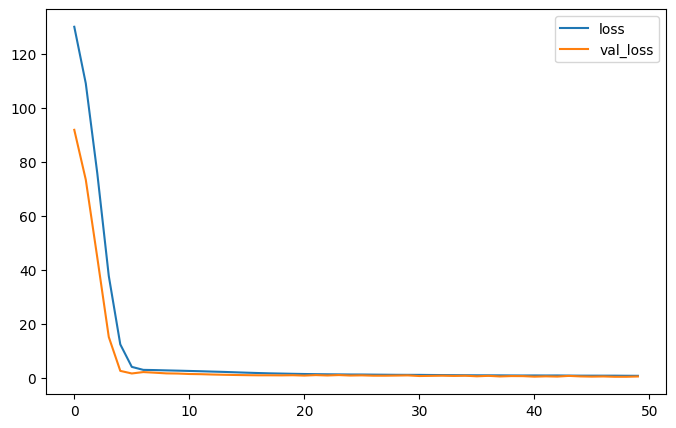

In [35]:
pd.DataFrame(historyMod2.history).plot(figsize=(8,5))

In [36]:
mse_test2=ModMLP2.evaluate(X_test,y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.5467 


In [37]:
print("Disminución en porcentaje de", 100*(1-mse_test2/mse_test1), "respecto al primer modelo")
print("Disminución en porcentaje de", 100*(1-mse_test2/mse_test1_1), "respecto al segundo modelo")
print("Disminución en porcentaje de", 100*(1-mse_test2/mse_test1_2), "respecto al tercer modelo")

Disminución en porcentaje de 54.194265859510324 respecto al primer modelo
Disminución en porcentaje de 39.669116948518266 respecto al segundo modelo
Disminución en porcentaje de 27.70723421799577 respecto al tercer modelo


In [38]:
ypred2=ModMLP2.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


<Figure size 600x600 with 0 Axes>

Text(0.5, 1.0, 'Real vs Predicción')

Text(0, 0.5, 'Tasa de Desempleo')

Text(0.5, 0, 'índice')

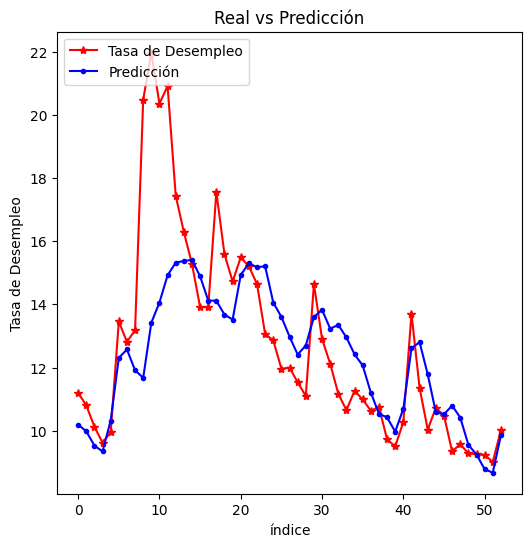

In [39]:
plt.figure(figsize=(6, 6))
plt.plot(range(y_test.size), y_test, linestyle='-', marker='*', color='r')
plt.plot(range(ypred2.size), ypred2, linestyle='-', marker='.', color='b') 
plt.legend(['Tasa de Desempleo','Predicción'], loc=2)
plt.title('Real vs Predicción')
plt.ylabel('Tasa de Desempleo')
plt.xlabel('índice')

Las predicciones mejoran a comparación del modelo anterior, en especial en los meses más recientes, el periodo correspondiente al 2020, como es de esperar, tiene una sub-estimación, sin embargo, visualmente se nota que el modelo se ajusta muy bien a los datos.

In [40]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(units=hp.Int("num_units", min_value=32, max_value=64, step=32),
                activation=hp.Choice("activation", ["relu", "tanh"])))
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 2)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=32, max_value=64, step=32),
                activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(1, activation="linear"))
    learning_rate = hp.Float("lr", min_value=1e-3, max_value=1e-2,step=0.003)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mean_squared_error",
        metrics=["mean_squared_error"]
    )
    return model


build_model(kt.HyperParameters())

<Sequential name=sequential_3, built=False>

### Búsqueda de los hiperparámetros utilizando Grid Search

In [41]:
tuner_GridSearch_mlp = kt.GridSearch(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=None,
    executions_per_trial=1,
    overwrite=True,
    directory="dirsalida",
    project_name="helloworld",
)

In [42]:
tuner_GridSearch_mlp.search_space_summary()

Search space summary
Default search space size: 6
num_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 64, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 64, 'step': 32, 'sampling': 'linear'}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.01, 'step': 0.003, 'sampling': 'linear'}


In [43]:
stop_early=keras.callbacks.EarlyStopping(monitor="val_loss",patience=2)

In [44]:
tuner_GridSearch_mlp.search(X_train,y_train, epochs=20, validation_data=(X_val,y_val),callbacks=[stop_early])

Trial 240 Complete [00h 00m 04s]
val_loss: 1.6552062034606934

Best val_loss So Far: 1.1210194826126099
Total elapsed time: 00h 11m 40s


In [45]:
# Get the top 2 models.
models_mlp = tuner_GridSearch_mlp.get_best_models(num_models=2)
best_model_mlp = models_mlp[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
# best_model_mlp.build(input_shape=(32, 1, 7))
# best_model_mlp.summary()

C:\Users\EQUIPO\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\EQUIPO\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


#### Los mejores 10 modelos

In [46]:
tuner_GridSearch_mlp.results_summary()

Results summary
Results in dirsalida\helloworld
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0217 summary
Hyperparameters:
num_units: 64
activation: tanh
num_layers: 2
units_0: 32
dropout: True
lr: 0.001
units_1: 64
Score: 1.1210194826126099

Trial 0064 summary
Hyperparameters:
num_units: 32
activation: tanh
num_layers: 1
units_0: 64
dropout: False
lr: 0.001
units_1: 32
Score: 1.1813057661056519

Trial 0104 summary
Hyperparameters:
num_units: 32
activation: tanh
num_layers: 2
units_0: 64
dropout: True
lr: 0.001
units_1: 32
Score: 1.2156410217285156

Trial 0096 summary
Hyperparameters:
num_units: 32
activation: tanh
num_layers: 2
units_0: 64
dropout: False
lr: 0.001
units_1: 32
Score: 1.2203631401062012

Trial 0188 summary
Hyperparameters:
num_units: 64
activation: tanh
num_layers: 1
units_0: 32
dropout: True
lr: 0.007
units_1: 32
Score: 1.226288914680481

Trial 0072 summary
Hyperparameters:
num_units: 32
activation: tanh
num_layers: 1
units_0: 64
dropout: T

### Modelo final
Finalmente se entrenará el mejor modelo con los datos de entrenamiento y validación.

In [47]:
callback=keras.callbacks.EarlyStopping(monitor="loss",patience=5)
best_hps_mlp = tuner_GridSearch_mlp.get_best_hyperparameters(2)
model_mlp = build_model(best_hps_mlp[0])
# Fit with the entire dataset.
model_mlp.fit(X_train_full,y_train_full, epochs=20 ,callbacks=[callback])

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 110.2918 - mean_squared_error: 110.2918  
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - loss: 72.1993 - mean_squared_error: 72.1993
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 44.2254 - mean_squared_error: 44.2254 
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - loss: 32.6728 - mean_squared_error: 32.6728
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - loss: 23.3645 - mean_squared_error: 23.3645
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - loss: 16.5707 - mean_squared_error: 16.5707
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.4810 - mean_squared_error: 12.4810 
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - loss: 8.9530 - mean_squared_error: 8.9530
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.0478 - mean_squared_error: 7.0478 
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - loss: 6.7307 - mean_squared_error: 6.7307
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/

In [48]:
model_mlp.layers[0].get_weights()[0]

array([[ 2.02665120e-01,  1.24004699e-01,  1.95403144e-01,
         1.06123321e-01,  2.75007665e-01,  1.48162991e-01,
        -2.19076812e-01, -1.78202584e-01,  1.85357213e-01,
         2.18444318e-01,  9.32833850e-02, -1.97070345e-01,
        -1.57153621e-01, -3.83875482e-02, -2.44098470e-01,
        -2.01217845e-01,  2.16651678e-01, -2.64102101e-01,
        -1.16630860e-01,  2.67443120e-01,  2.29085106e-02,
        -1.92432418e-01,  1.15544774e-01,  1.41345114e-01,
        -1.47617713e-01, -9.36977491e-02,  1.03287287e-01,
        -2.17137650e-01, -1.04424000e-01, -2.30821252e-01,
        -3.33882123e-02,  2.11362198e-01,  2.33927026e-01,
        -1.30644083e-01, -2.38938272e-01, -2.99531668e-01,
        -2.36957923e-01,  2.93656047e-02,  1.74063832e-01,
        -2.25129068e-01,  6.03145286e-02,  1.64271906e-01,
         2.80235082e-01, -2.07459740e-02,  2.46781901e-01,
        -1.62909552e-01,  1.19535565e-01,  1.03321791e-01,
         2.05683917e-01, -1.50748789e-01, -8.78541321e-0

In [49]:
print(model_mlp.layers[0].bias.numpy())

[ 1.48611646e-02  4.20084270e-03 -1.78113226e-02 -1.48340669e-02
  1.16385743e-02 -1.71471313e-02 -9.28259362e-03  1.81796420e-02
  2.56256219e-02 -1.23473108e-02 -1.60164293e-02 -1.89676061e-02
  1.44836027e-02 -2.42781714e-02 -3.67596542e-04 -1.41902175e-02
  4.32678033e-04 -1.69351362e-02  2.70727798e-02  8.79630388e-04
  1.61167402e-02 -2.19326057e-02 -3.17255524e-03  1.14221498e-02
  3.61687783e-03 -4.29515276e-05  1.46565158e-02  4.51089218e-02
 -2.15664338e-02  1.37312450e-02  2.00366862e-02  8.00132751e-03
 -1.63435303e-02  1.21786445e-02  2.07208712e-02 -2.61116978e-02
  1.32207917e-02  1.32424301e-02  4.14219536e-02 -1.89579709e-03
 -1.48454607e-02  1.60110462e-02  9.01711732e-03  1.83084626e-02
  3.85788307e-02  0.00000000e+00  1.62310693e-02 -1.39480624e-02
  1.52499946e-02 -1.24308551e-02 -1.11245606e-02  0.00000000e+00
  1.56883877e-02 -3.18880123e-03  1.62899382e-02 -3.44500644e-03
  8.59458745e-03 -6.59314618e-02  1.52486144e-02  1.39065403e-02
 -1.08170481e-02  1.32725

In [50]:
X_test.shape

(53, 14)

In [51]:
prediction_test=model_mlp.predict( X_test, verbose=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [52]:
y_test=y_test.reshape((y_test.shape[0], 1))

In [53]:
errors_squared=keras.metrics.MeanSquaredError()
errors_squared.update_state(y_test, prediction_test)
print("ECM:",errors_squared.result().numpy())

ECM: 26.360126


Text(0, 0.5, 'Y y $\\hat{Y}$ en conjunto de prueba')

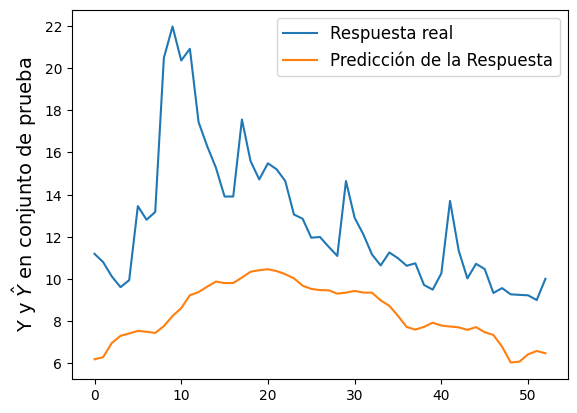

In [54]:
plt.plot(y_test)
plt.plot(prediction_test)
plt.legend(['Respuesta real','Predicción de la Respuesta'],loc="best", fontsize=12)
plt.ylabel('Y y $\hat{Y}$ en conjunto de prueba', fontsize=14)

Text(0, 0.5, '$\\hat{e}$ en conjunto de prueba')

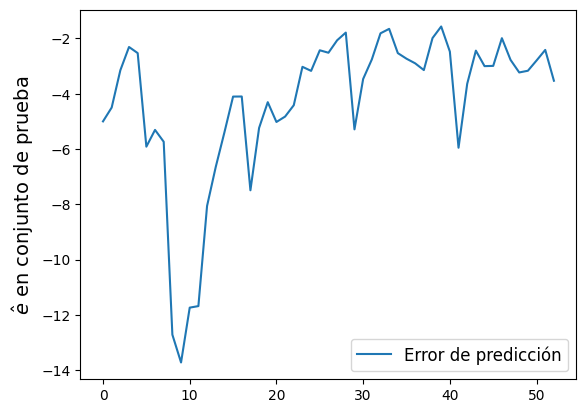

In [55]:
#Gráfico de errores
plt.plot(prediction_test-y_test)
plt.legend(['Error de predicción'],loc="best", fontsize=12)
plt.ylabel('$\hat{e}$ en conjunto de prueba', fontsize=14)